In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import scipy

c_speed = 299792458        # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]

plt.rcParams['image.cmap']='cividis'

import sscCdi, sscCdiApps
sscCdi.__version__, sscCdiApps.__version__

('0.14.0', '0.0.9')

In [7]:
# SIEMENS BIG FOV
path = '/ibira/lnls/beamlines/mogno/proposals/20210106/data/20240321_GCC_Commissioning_Experiment/Ptycho_square/raw/ptycho_z1_50_z1z2_1000_032.hdf5'

data = h5py.File(path, 'r')
DPs = data['scan/detector/data'][()]
positions = data['scan/detector/positions'][()][:,0:2]*1e-3 # convert to meters

z1 = 50e-3 # source to sample
z1z2 =  0.98 # z1+z2 # source to detector

DPs.shape, positions.shape

((400, 2048, 2048), (400, 2))

In [3]:
z2 = z1z2 - z1
M = (z2+z1)/z1
print('M = ', M)
n_pixels = 2048
inputs = {
"n_cpus": 32, # cpu cores
"energy": 22, #keV
"detector_distance": z2/M, # meter
"detector_pixel_size": 1.44e-6/M,
"source_distance": 0, # should be 0 if parallel beam
"iterations": 10,
"fresnel_regime": True,
'regime': 'fresnel',
"probe_support": None,
"incoherent_modes": 1,
"beta": 0.9, # RAAR beta
"epsilon":0.01, # RAAR; small value to add to probe/object update denominator
"object_padding": 500, # border pixels to guarantee enough FOV during scan
}

inputs['regularization_probe'] = 0.001
inputs['regularization_obj'] = 0.001
inputs['probe_support_array'] = np.ones_like(DPs[0])
inputs['distance_sample_focus'] = 0
inputs['free_log_likelihood'] = 0
inputs['fourier_power_bound'] = 0.5
inputs['clip_object_magnitude'] = False
inputs["wavelength"] = c_speed * planck / inputs["energy"]
inputs['object_pixel'] = inputs["detector_pixel_size"] # if not using /M for the detector pixel size above, /M should be included here
print(f'Object pixel = {inputs["object_pixel"]} m')

probe = np.ones_like(DPs[0])
print(f'Probe shape = {probe.shape}')

positions_pxl = sscCdiApps.convert_probe_mogno_positions_meters_to_pixels(positions.copy(),inputs["object_pixel"],inputs["object_padding"])


size_in_bytes = DPs.nbytes # Get the size of the array in bytes
size_in_gb = size_in_bytes / (1024**3) # Convert the size to gigabytes
print("Size of the array:", size_in_gb, "GB")

inputs["object_shape"] = sscCdi.set_object_shape(inputs["object_padding"], DPs.shape, positions_pxl)
print(f'Object shape = {inputs["object_shape"]}')

print(f'Data shape = {DPs.shape}')
print(f'Positions shape = {positions_pxl.shape}')

model_object = np.ones(inputs["object_shape"])

probe_guess = np.ones_like(probe) + 1j
probe_guess = probe + 1j
obj_guess = np.ones_like(model_object) # constant object

print(f"Probe guess: {probe_guess.shape}")
print(f"Obj guess: {obj_guess.shape}")


M =  19.599999999999998
Object pixel = 7.346938775510205e-08 m
Probe shape = (2048, 2048)
Size of the array: 3.125 GB
Object shape = (3881, 3879)
Data shape = (400, 2048, 2048)
Positions shape = (400, 2)
Probe guess: (2048, 2048)
Obj guess: (3881, 3879)


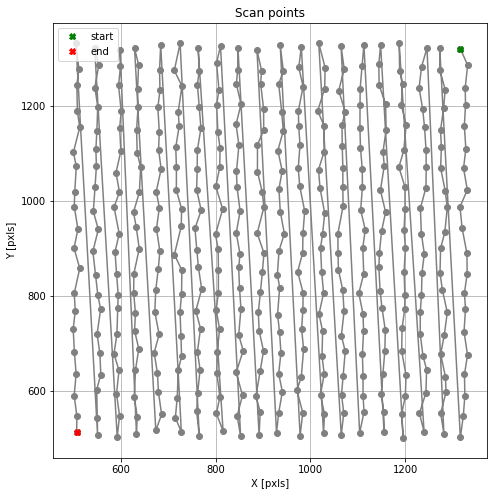

In [4]:
sscCdi.plot_ptycho_scan_points(positions_pxl)

In [5]:
sscCdi.misc.slice_visualizer(DPs,type='abs',title='CC',cmap='cividis',axis=0) # select axis

In [6]:
RAAR_obj, RAAR_probes, _ = sscCdi.RAAR_python(DPs,positions_pxl,obj_guess,probe_guess,inputs)

propagated_probe = sscCdi.fresnel_propagator_cone_beam(RAAR_probes[0],inputs["wavelength"],inputs["detector_pixel_size"],inputs["detector_distance"],inputs["source_distance"]) 

RAAR_obj.shape, RAAR_probes.shape

Using CuPy (GPU)
Transfering data to GPU...
Object shape: (1, 3881, 3879)
Probe shape: (1, 2048, 2048)
Diffraction patterns shape: (400, 2048, 2048)
Wavefronts shape: (400, 1, 2048, 2048)
Positions shape: (400, 2)
	Iteration 10/10 	 Errors: R-factor=4.65e-01; MSE=nan; Poisson LLK=nan



((3881, 3879), (1, 2048, 2048))

Text(0.5, 0.98, 'Near Field Ptychography')

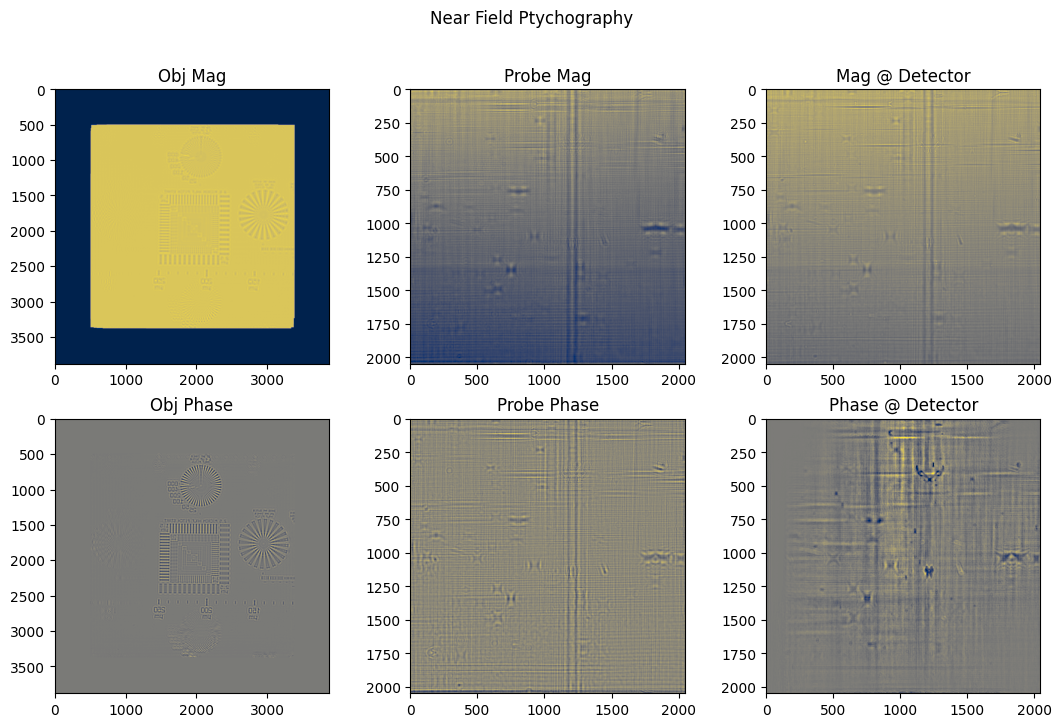

In [8]:
fig, ax = plt.subplots(2,3,figsize=(13,8),dpi=100)
ax[0,0].imshow(np.abs(RAAR_obj)), ax[0,0].set_title('Obj Mag')
# ax[0,0].plot(positions[:,0],positions[:,1],'x',color='gray')
ax[1,0].imshow(np.angle(RAAR_obj)), ax[1,0].set_title('Obj Phase')
ax[0,1].imshow(np.abs(RAAR_probes[0])), ax[0,1].set_title('Probe Mag')
ax[1,1].imshow(np.angle(RAAR_probes[0])), ax[1,1].set_title('Probe Phase')
ax[0,2].imshow(np.abs(propagated_probe)), ax[0,2].set_title('Mag @ Detector')
mean = np.mean(np.angle(propagated_probe))
std=np.std(np.angle(propagated_probe))
ax[1,2].imshow(np.angle(propagated_probe),vmin=mean-4*std,vmax=mean+4*std), ax[1,2].set_title('Phase @ Detector')

fig.suptitle('Near Field Ptychography')